In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from math import sqrt, ceil, floor
import matplotlib.pyplot as plt
from xgboost import plot_importance
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from joblib import dump, load
%matplotlib inline

In [ ]:
train = pd.read_csv('../processed_data_and_models/Training_Dataset.csv')
train.rename({'available_hours':'online_hours'}, axis = 1, inplace = True)
train = train[['date','driver_id','dayofweek','weekend','gender','age','number_of_kids','online_hours']]

train['dayofweek']= train['dayofweek'].astype('int64')
train['age']= train['age'].astype('int64')
train['number_of_kids']= train['number_of_kids'].astype('int64')

In [ ]:
test = pd.read_csv('../processed_data_and_models/driver_test.csv').sort_values(by = ['driver_id','date'])
test.columns

Index(['driver_id', 'date', 'online_hours', 'dayofweek', 'weekend', 'gender',
       'age', 'number_of_kids'],
      dtype='object')

In [ ]:
test = test[train.columns]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52437 entries, 0 to 52436
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            52437 non-null  object 
 1   driver_id       52437 non-null  int64  
 2   dayofweek       52437 non-null  int64  
 3   weekend         52437 non-null  int64  
 4   gender          52437 non-null  int64  
 5   age             52437 non-null  int64  
 6   number_of_kids  52437 non-null  int64  
 7   online_hours    52437 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 3.2+ MB


In [ ]:
train.head(21)

,date,driver_id,dayofweek,weekend,gender,age,number_of_kids,online_hours
0,2017-06-01,111556,3,0,1,49,4,2.2
1,2017-06-02,111556,4,0,1,49,4,2.5
2,2017-06-03,111556,5,1,1,49,4,0.0
3,2017-06-04,111556,6,1,1,49,4,0.0
4,2017-06-05,111556,0,0,1,49,4,4.7
5,2017-06-06,111556,1,0,1,49,4,3.1
6,2017-06-07,111556,2,0,1,49,4,2.6
7,2017-06-08,111556,3,0,1,49,4,3.2
8,2017-06-09,111556,4,0,1,49,4,4.4
9,2017-06-10,111556,5,1,1,49,4,0.0


In [ ]:
test.head(7)

,date,driver_id,dayofweek,weekend,gender,age,number_of_kids,online_hours
181,2017-06-22,111556,3,0,1,49,4,2
180,2017-06-23,111556,4,0,1,49,4,5
179,2017-06-24,111556,5,1,1,49,4,0
178,2017-06-25,111556,6,1,1,49,4,0
177,2017-06-26,111556,0,0,1,49,4,0
176,2017-06-27,111556,1,0,1,49,4,3
175,2017-06-28,111556,2,0,1,49,4,3


In [ ]:
X = train.iloc[:,2:-1]
y = train.iloc[:,-1]
X_test = test.iloc[:,2:-1]
y_test = test.iloc[:,-1]

In [ ]:
def metrics_calculate(regressor):
    y_pred = regressor.predict(X_test)
    rms = sqrt(mean_squared_error(y_test, y_pred))
    return (rms)

<hr>

# Iteration 1
Features: ['online_hours', 'dayofweek', 'weekend', 'gender',
       'age', 'number_of_kids']

In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression().fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

RMSE TRAIN: 3.131822263095636, RMSE TEST:3.1663369893681534


### Linear Regressor RMSE Train: 3.13, RMSE: Test: 3.16
### Linear Regressor underfits
#### It is used to determine the extent to which there is a linear relationship between a dependent variable and one or more independent variables.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor()
regressor.fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

RMSE TRAIN: 2.915525266735946, RMSE TEST:3.0078528522498154


### Decision Tree RMSE Train: 2.91 and Test: 3.0

<hr>

##### Moving to Ensemble Regressors: Bagging Algorithm Random Forest 
#### Random Forest Regressor: Random forests are bagged decision tree models that split on a subset of features on each split.
#### Give Feature importance based on target variable

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 300, random_state=0, n_jobs = -1)
regressor.fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

RMSE TRAIN: 2.9157921633839097, RMSE TEST:3.0073878791952673


In [ ]:
print ("Features score:")
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

Features score:


,importance
age,0.339230
gender,0.279718
dayofweek,0.198872
number_of_kids,0.134963
weekend,0.047216


### Moving to a Ensemble: Boosting Algorithm
+ Here: learners are learned sequentially

In [ ]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=8000, max_depth=8, objective="reg:squarederror")

eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set, early_stopping_rounds=30,eval_metric="rmse")
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

[0]	validation_0-rmse:5.16258
Will train until validation_0-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:5.12989
[2]	validation_0-rmse:5.09767
[3]	validation_0-rmse:5.06588
[4]	validation_0-rmse:5.03444
[5]	validation_0-rmse:5.00353
[6]	validation_0-rmse:4.97304
[7]	validation_0-rmse:4.94292
[8]	validation_0-rmse:4.9132
[9]	validation_0-rmse:4.88393
[10]	validation_0-rmse:4.85508
[11]	validation_0-rmse:4.82666
[12]	validation_0-rmse:4.79859
[13]	validation_0-rmse:4.77089
[14]	validation_0-rmse:4.74363
[15]	validation_0-rmse:4.71674
[16]	validation_0-rmse:4.69024
[17]	validation_0-rmse:4.66412
[18]	validation_0-rmse:4.63841
[19]	validation_0-rmse:4.613
[20]	validation_0-rmse:4.588
[21]	validation_0-rmse:4.56334
[22]	validation_0-rmse:4.53905
[23]	validation_0-rmse:4.51511
[24]	validation_0-rmse:4.49149
[25]	validation_0-rmse:4.46829
[26]	validation_0-rmse:4.44535
[27]	validation_0-rmse:4.42278
[28]	validation_0-rmse:4.40053
[29]	validation_0-rmse:4.37857
[30]	validation_0-rm

[259]	validation_0-rmse:3.08004
[260]	validation_0-rmse:3.07953
[261]	validation_0-rmse:3.07904
[262]	validation_0-rmse:3.07854
[263]	validation_0-rmse:3.07805
[264]	validation_0-rmse:3.0776
[265]	validation_0-rmse:3.07713
[266]	validation_0-rmse:3.0766
[267]	validation_0-rmse:3.07616
[268]	validation_0-rmse:3.07575
[269]	validation_0-rmse:3.07529
[270]	validation_0-rmse:3.0749
[271]	validation_0-rmse:3.07445
[272]	validation_0-rmse:3.07403
[273]	validation_0-rmse:3.07361
[274]	validation_0-rmse:3.07317
[275]	validation_0-rmse:3.07275
[276]	validation_0-rmse:3.07234
[277]	validation_0-rmse:3.07191
[278]	validation_0-rmse:3.07152
[279]	validation_0-rmse:3.07116
[280]	validation_0-rmse:3.07081
[281]	validation_0-rmse:3.07042
[282]	validation_0-rmse:3.07006
[283]	validation_0-rmse:3.06968
[284]	validation_0-rmse:3.06935
[285]	validation_0-rmse:3.06901
[286]	validation_0-rmse:3.06865
[287]	validation_0-rmse:3.06831
[288]	validation_0-rmse:3.068
[289]	validation_0-rmse:3.06769
[290]	validat

[516]	validation_0-rmse:3.03238
[517]	validation_0-rmse:3.03228
[518]	validation_0-rmse:3.03225
[519]	validation_0-rmse:3.03216
[520]	validation_0-rmse:3.03207
[521]	validation_0-rmse:3.03204
[522]	validation_0-rmse:3.03196
[523]	validation_0-rmse:3.03192
[524]	validation_0-rmse:3.03182
[525]	validation_0-rmse:3.03174
[526]	validation_0-rmse:3.03172
[527]	validation_0-rmse:3.03163
[528]	validation_0-rmse:3.03161
[529]	validation_0-rmse:3.03156
[530]	validation_0-rmse:3.03148
[531]	validation_0-rmse:3.03145
[532]	validation_0-rmse:3.03139
[533]	validation_0-rmse:3.03135
[534]	validation_0-rmse:3.0313
[535]	validation_0-rmse:3.03126
[536]	validation_0-rmse:3.03119
[537]	validation_0-rmse:3.03116
[538]	validation_0-rmse:3.03109
[539]	validation_0-rmse:3.03105
[540]	validation_0-rmse:3.03099
[541]	validation_0-rmse:3.0309
[542]	validation_0-rmse:3.03081
[543]	validation_0-rmse:3.03073
[544]	validation_0-rmse:3.03064
[545]	validation_0-rmse:3.03061
[546]	validation_0-rmse:3.03052
[547]	vali

[773]	validation_0-rmse:3.01728
[774]	validation_0-rmse:3.01726
[775]	validation_0-rmse:3.0172
[776]	validation_0-rmse:3.01718
[777]	validation_0-rmse:3.01713
[778]	validation_0-rmse:3.01707
[779]	validation_0-rmse:3.01706
[780]	validation_0-rmse:3.017
[781]	validation_0-rmse:3.01695
[782]	validation_0-rmse:3.01694
[783]	validation_0-rmse:3.01689
[784]	validation_0-rmse:3.01687
[785]	validation_0-rmse:3.01682
[786]	validation_0-rmse:3.01675
[787]	validation_0-rmse:3.01669
[788]	validation_0-rmse:3.01668
[789]	validation_0-rmse:3.01662
[790]	validation_0-rmse:3.0166
[791]	validation_0-rmse:3.01656
[792]	validation_0-rmse:3.01655
[793]	validation_0-rmse:3.01654
[794]	validation_0-rmse:3.01649
[795]	validation_0-rmse:3.01646
[796]	validation_0-rmse:3.01644
[797]	validation_0-rmse:3.01643
[798]	validation_0-rmse:3.01638
[799]	validation_0-rmse:3.01637
[800]	validation_0-rmse:3.01636
[801]	validation_0-rmse:3.01634
[802]	validation_0-rmse:3.01631
[803]	validation_0-rmse:3.0163
[804]	validat

[1030]	validation_0-rmse:3.00855
[1031]	validation_0-rmse:3.00854
[1032]	validation_0-rmse:3.00852
[1033]	validation_0-rmse:3.00847
[1034]	validation_0-rmse:3.00847
[1035]	validation_0-rmse:3.00845
[1036]	validation_0-rmse:3.00844
[1037]	validation_0-rmse:3.00841
[1038]	validation_0-rmse:3.00839
[1039]	validation_0-rmse:3.00838
[1040]	validation_0-rmse:3.00837
[1041]	validation_0-rmse:3.00835
[1042]	validation_0-rmse:3.00831
[1043]	validation_0-rmse:3.00828
[1044]	validation_0-rmse:3.00824
[1045]	validation_0-rmse:3.00822
[1046]	validation_0-rmse:3.0082
[1047]	validation_0-rmse:3.00819
[1048]	validation_0-rmse:3.00817
[1049]	validation_0-rmse:3.00816
[1050]	validation_0-rmse:3.00813
[1051]	validation_0-rmse:3.00809
[1052]	validation_0-rmse:3.00806
[1053]	validation_0-rmse:3.00804
[1054]	validation_0-rmse:3.00801
[1055]	validation_0-rmse:3.008
[1056]	validation_0-rmse:3.00799
[1057]	validation_0-rmse:3.00795
[1058]	validation_0-rmse:3.00793
[1059]	validation_0-rmse:3.0079
[1060]	validat

[1280]	validation_0-rmse:3.0047
[1281]	validation_0-rmse:3.00468
[1282]	validation_0-rmse:3.00469
[1283]	validation_0-rmse:3.00468
[1284]	validation_0-rmse:3.00467
[1285]	validation_0-rmse:3.00468
[1286]	validation_0-rmse:3.00468
[1287]	validation_0-rmse:3.00468
[1288]	validation_0-rmse:3.00468
[1289]	validation_0-rmse:3.00467
[1290]	validation_0-rmse:3.00468
[1291]	validation_0-rmse:3.00468
[1292]	validation_0-rmse:3.00468
[1293]	validation_0-rmse:3.00467
[1294]	validation_0-rmse:3.00467
[1295]	validation_0-rmse:3.00468
[1296]	validation_0-rmse:3.00467
[1297]	validation_0-rmse:3.00467
[1298]	validation_0-rmse:3.00466
[1299]	validation_0-rmse:3.00465
[1300]	validation_0-rmse:3.00464
[1301]	validation_0-rmse:3.00464
[1302]	validation_0-rmse:3.00463
[1303]	validation_0-rmse:3.00462
[1304]	validation_0-rmse:3.00462
[1305]	validation_0-rmse:3.00461
[1306]	validation_0-rmse:3.00461
[1307]	validation_0-rmse:3.0046
[1308]	validation_0-rmse:3.0046
[1309]	validation_0-rmse:3.00459
[1310]	valida

[1530]	validation_0-rmse:3.00293
[1531]	validation_0-rmse:3.00293
[1532]	validation_0-rmse:3.00293
[1533]	validation_0-rmse:3.00292
[1534]	validation_0-rmse:3.00292
[1535]	validation_0-rmse:3.00292
[1536]	validation_0-rmse:3.00292
[1537]	validation_0-rmse:3.00291
[1538]	validation_0-rmse:3.00292
[1539]	validation_0-rmse:3.00291
[1540]	validation_0-rmse:3.00291
[1541]	validation_0-rmse:3.00291
[1542]	validation_0-rmse:3.0029
[1543]	validation_0-rmse:3.00289
[1544]	validation_0-rmse:3.00289
[1545]	validation_0-rmse:3.00287
[1546]	validation_0-rmse:3.00286
[1547]	validation_0-rmse:3.00284
[1548]	validation_0-rmse:3.00284
[1549]	validation_0-rmse:3.00284
[1550]	validation_0-rmse:3.00284
[1551]	validation_0-rmse:3.00283
[1552]	validation_0-rmse:3.00283
[1553]	validation_0-rmse:3.00282
[1554]	validation_0-rmse:3.0028
[1555]	validation_0-rmse:3.00279
[1556]	validation_0-rmse:3.00279
[1557]	validation_0-rmse:3.00278
[1558]	validation_0-rmse:3.00276
[1559]	validation_0-rmse:3.00276
[1560]	valid

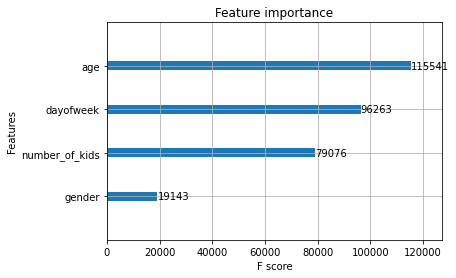

In [ ]:
# plot feature importance
plot_importance(model)

### Comment- Train RMSE:2.93  ; Test RMSE: 3.002

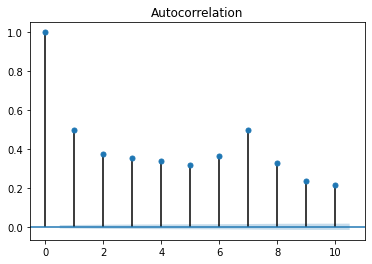

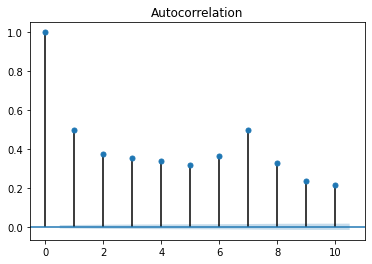

In [ ]:
plot_acf(train['online_hours'], lags=10)

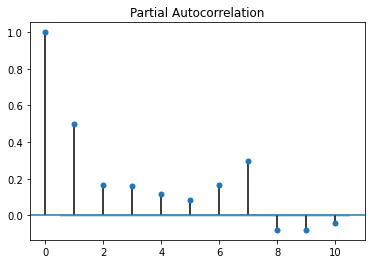

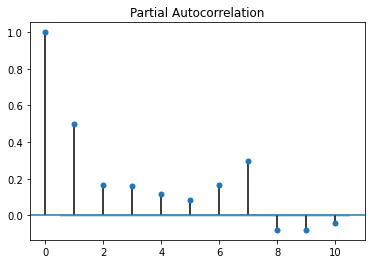

In [ ]:
plot_pacf(train['online_hours'], lags=10)


+ ACF: The ACF plot is a measure of the correlation between the time series and the lagged version of itself
+ PACF: The PACF plot is a measure of the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons

In [ ]:
test = test.sort_values(by=['driver_id', 'date']).drop_duplicates(subset=['date','driver_id'])
temp = pd.concat([train,test])
temp = temp.sort_values(by=['driver_id', 'date']).drop_duplicates(subset=['date','driver_id'])
temp = temp.set_index(['date', 'driver_id', 'dayofweek', 'weekend', 'gender', 'age',
       'number_of_kids'])

temp['lag_1'] = temp.groupby(level=['driver_id'])['online_hours'].shift(1)
temp['lag_2'] = temp.groupby(level=['driver_id'])['online_hours'].shift(2)
temp['lag_3'] = temp.groupby(level=['driver_id'])['online_hours'].shift(3)
temp['lag_4'] = temp.groupby(level=['driver_id'])['online_hours'].shift(4)
temp['lag_5'] = temp.groupby(level=['driver_id'])['online_hours'].shift(5)
temp['lag_6'] = temp.groupby(level=['driver_id'])['online_hours'].shift(6)
temp['lag_7'] = temp.groupby(level=['driver_id'])['online_hours'].shift(7)
temp.head(15)

,,,,,,,online_hours,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,driver_id,dayofweek,weekend,gender,age,number_of_kids,,,,,,,,
2017-06-01,111556,3,0,1,49,4,2.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-02,111556,4,0,1,49,4,2.5,2.2,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-03,111556,5,1,1,49,4,0.0,2.5,2.2,NaN,NaN,NaN,NaN,NaN
2017-06-04,111556,6,1,1,49,4,0.0,0.0,2.5,2.2,NaN,NaN,NaN,NaN
2017-06-05,111556,0,0,1,49,4,4.7,0.0,0.0,2.5,2.2,NaN,NaN,NaN
2017-06-06,111556,1,0,1,49,4,3.1,4.7,0.0,0.0,2.5,2.2,NaN,NaN
2017-06-07,111556,2,0,1,49,4,2.6,3.1,4.7,0.0,0.0,2.5,2.2,NaN
2017-06-08,111556,3,0,1,49,4,3.2,2.6,3.1,4.7,0.0,0.0,2.5,2.2
2017-06-09,111556,4,0,1,49,4,4.4,3.2,2.6,3.1,4.7,0.0,0.0,2.5


In [ ]:
temp = temp.reset_index(drop = False).dropna()
temp = temp[['date', 'driver_id', 'dayofweek', 'weekend', 'gender', 'age',
       'number_of_kids', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'online_hours']]
train1 = temp[temp['date']<='2017-06-21']
test1 = temp[temp['date']>='2017-06-22']

X = train1.iloc[:, 2:-1]
y = train1.iloc[:, -1]
X_test = test1.iloc[:, 2:-1]
y_test = test1.iloc[:, -1]


In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state=0, n_jobs = -1)
regressor.fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

RMSE TRAIN: 0.7113081465946146, RMSE TEST:2.030734817858652


## Result: Train RMSE: 0.71 | Test RMSE: 2.03

In [ ]:
print ("Features score:")
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)
feature_importances

Features score:


,importance
lag_7,0.571107
lag_1,0.071839
lag_6,0.057736
lag_4,0.051865
age,0.050580
lag_5,0.044672
lag_2,0.044070
lag_3,0.041695
dayofweek,0.031170
number_of_kids,0.014703


In [ ]:
X.head(10)

,dayofweek,weekend,gender,age,number_of_kids,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
7,3,0,1,49,4,2.6,3.1,4.7,0.0,0.0,2.5,2.2
8,4,0,1,49,4,3.2,2.6,3.1,4.7,0.0,0.0,2.5
9,5,1,1,49,4,4.4,3.2,2.6,3.1,4.7,0.0,0.0
10,6,1,1,49,4,0.0,4.4,3.2,2.6,3.1,4.7,0.0
11,0,0,1,49,4,0.0,0.0,4.4,3.2,2.6,3.1,4.7
12,1,0,1,49,4,3.7,0.0,0.0,4.4,3.2,2.6,3.1
13,2,0,1,49,4,4.4,3.7,0.0,0.0,4.4,3.2,2.6
14,3,0,1,49,4,2.0,4.4,3.7,0.0,0.0,4.4,3.2
15,4,0,1,49,4,1.0,2.0,4.4,3.7,0.0,0.0,4.4
16,5,1,1,49,4,0.0,1.0,2.0,4.4,3.7,0.0,0.0


In [ ]:
assert len(X) == 14*2497

In [ ]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=1000, max_depth=8, objective="reg:squarederror")

eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set, early_stopping_rounds=30,eval_metric="rmse")
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

[0]	validation_0-rmse:5.15194
Will train until validation_0-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:5.10808
[2]	validation_0-rmse:5.06479
[3]	validation_0-rmse:5.02189
[4]	validation_0-rmse:4.97955
[5]	validation_0-rmse:4.93761
[6]	validation_0-rmse:4.89638
[7]	validation_0-rmse:4.85546
[8]	validation_0-rmse:4.8152
[9]	validation_0-rmse:4.77534
[10]	validation_0-rmse:4.73595
[11]	validation_0-rmse:4.69706
[12]	validation_0-rmse:4.65861
[13]	validation_0-rmse:4.62053
[14]	validation_0-rmse:4.58303
[15]	validation_0-rmse:4.54599
[16]	validation_0-rmse:4.50929
[17]	validation_0-rmse:4.47312
[18]	validation_0-rmse:4.43738
[19]	validation_0-rmse:4.40205
[20]	validation_0-rmse:4.36717
[21]	validation_0-rmse:4.33269
[22]	validation_0-rmse:4.29857
[23]	validation_0-rmse:4.26497
[24]	validation_0-rmse:4.23175
[25]	validation_0-rmse:4.19886
[26]	validation_0-rmse:4.16642
[27]	validation_0-rmse:4.13433
[28]	validation_0-rmse:4.10269
[29]	validation_0-rmse:4.07137
[30]	validation_

[259]	validation_0-rmse:2.03989
[260]	validation_0-rmse:2.03937
[261]	validation_0-rmse:2.03884
[262]	validation_0-rmse:2.03831
[263]	validation_0-rmse:2.03777
[264]	validation_0-rmse:2.03725
[265]	validation_0-rmse:2.03678
[266]	validation_0-rmse:2.0363
[267]	validation_0-rmse:2.03584
[268]	validation_0-rmse:2.03537
[269]	validation_0-rmse:2.03495
[270]	validation_0-rmse:2.03449
[271]	validation_0-rmse:2.03402
[272]	validation_0-rmse:2.03362
[273]	validation_0-rmse:2.03322
[274]	validation_0-rmse:2.03284
[275]	validation_0-rmse:2.03244
[276]	validation_0-rmse:2.03208
[277]	validation_0-rmse:2.03175
[278]	validation_0-rmse:2.0314
[279]	validation_0-rmse:2.03107
[280]	validation_0-rmse:2.03069
[281]	validation_0-rmse:2.03033
[282]	validation_0-rmse:2.02999
[283]	validation_0-rmse:2.02964
[284]	validation_0-rmse:2.02931
[285]	validation_0-rmse:2.02901
[286]	validation_0-rmse:2.0287
[287]	validation_0-rmse:2.02839
[288]	validation_0-rmse:2.02813
[289]	validation_0-rmse:2.02779
[290]	valid

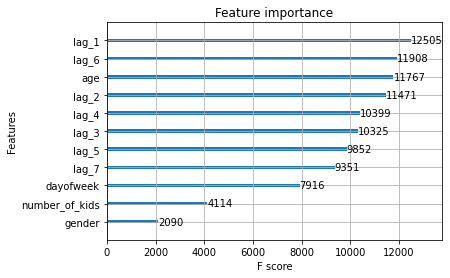

In [ ]:
plot_importance(model)

### Comment: RMSE on Training is reduced but Test RMSE has also seen slight change. (Lag Features has good feature importance)
### Train RMSE: 1.66 ; Test RMSE: 2.01